# Détection des faux Billets

Votre société de consulting informatique vous propose une nouvelle mission : créer un algorithme de détection de faux billets.

Le [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)  contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

 - la longueur du billet (en mm) ;  
 - la hauteur du billet (mesurée sur le côté gauche, en mm) ;  
 - La hauteur du billet (mesurée sur le côté droit, en mm) ;  
 - la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  
 - la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  
 - la diagonale du billet (en mm).

L'étude va consister en 3 parties : 

Partie 1 : analyse exploratoire univariée et bivariée de votre jeu de données  
Partie 2 : ACP 
    Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :  

analyse de l'éboulis des valeurs propres ;
représentation des variables par le cercle des corrélations ;
représentation des individus par les plans factoriels ;
analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

Si besoin de compléments sur l'ACP, n'hésitez pas à vous référez à [cours](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5280368-comprenez-lenjeu-de-lanalyse-en-composantes-principales) si besoin pour la partie plus théorique

Partie 3 : Réaliser une classification des billets (révisions de kmeans ou régression logique, et aller creuser côté CAH)

In [2]:
# Import des librairies
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.stats as scs
from scipy.stats import ks_2samp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.api import Logit

from math import pi

## Partie 0 : ANALYSES BIVARIES

Dans cette partie, vous allez explorer vos données via des visualisations, par exemple :   
    
    - le nombre de billets vrai/faux  
    - les distributions de longueurs, largeurs and co des billets de votre dataset
    - longueur/largeur and co des billets vrais vs. faux
    - etc -> be creative :)

In [3]:
df=pd.read_csv('./notes.csv')
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


Text(0.5, 1.0, 'Proportion de faux billets')

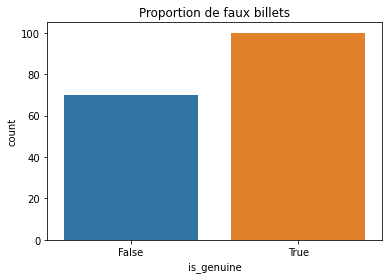

In [4]:
sns.countplot(df.is_genuine)
plt.title("Proportion de faux billets")

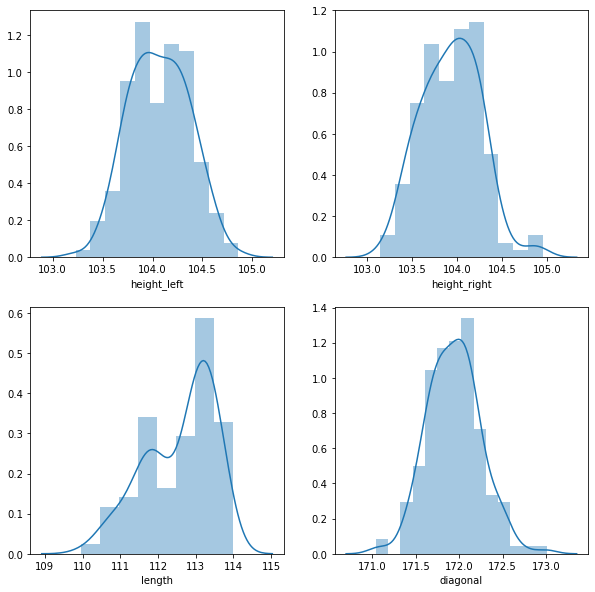

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(df.height_left)
plt.subplot(2,2,2)
sns.distplot(df.height_right)
plt.subplot(2,2,3)
sns.distplot(df.length)
plt.subplot(2,2,4)
sns.distplot(df.diagonal)

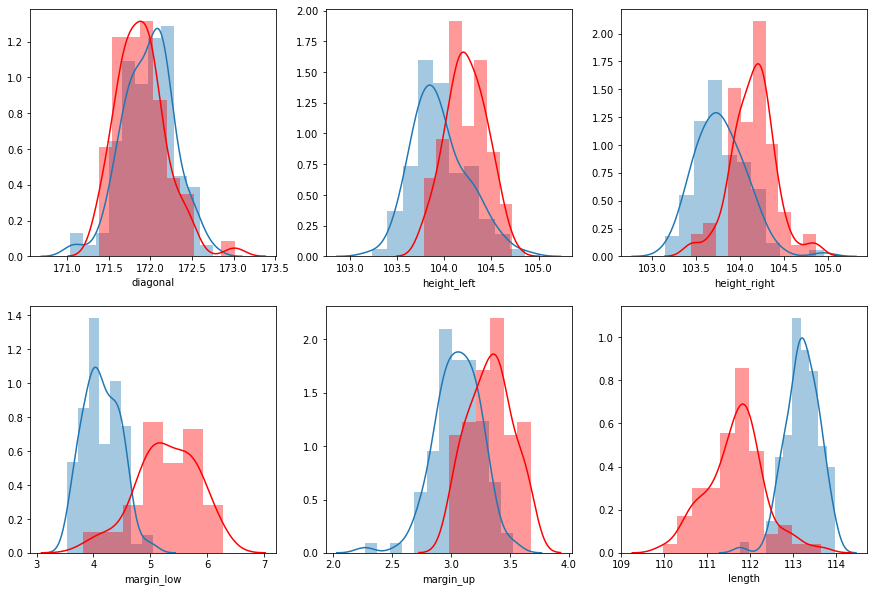

In [6]:
listeC=df.iloc[:,1:].columns
n=1
plt.figure(figsize=(15,10))
for i in listeC:
    plt.subplot(2,3,n)
    sns.distplot(df[i].loc[df["is_genuine"] == True])
    sns.distplot(df[i].loc[df["is_genuine"] == False], color= "red")
    n=n+1

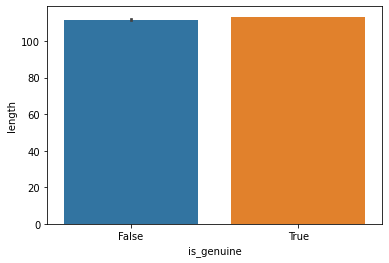

In [7]:
sns.barplot(df.is_genuine, df.length)

In [8]:
dfmoyenne= df.groupby(by="is_genuine").mean()
dfmoyenne

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


In [9]:
Fmoy=dfmoyenne.iloc[0,:].values
Tmoy=dfmoyenne.iloc[1,:].values
listeN=dfmoyenne.columns
listeN

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

([<matplotlib.patches.Wedge at 0x20ccad57850>,
 [Text(0.3010292715984893, 1.058008212463818, ''),
  Text(-0.30102917254061, -1.0580082406482079, '')])

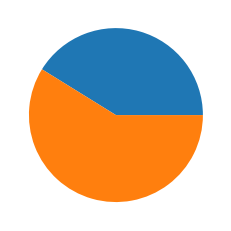

In [10]:
plt.pie(df.is_genuine.groupby(df["is_genuine"]).count())

Text(0.5, 1.0, 'Statistiques des faux billets')

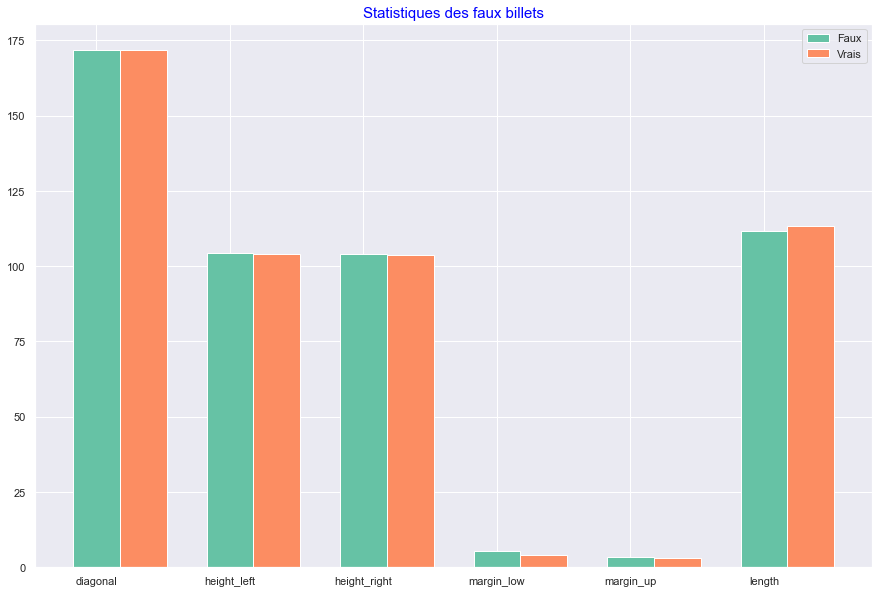

In [11]:
N= 5 #Nombre de catégorie
ind= [0,1,2,3,4,5]
ind2=[0.35,1.35,2.35,3.35,4.35,5.35]
width= 0.35
sns.set(palette='Set2')
plt.figure(figsize=[15,10])
p1= plt.bar(ind, Fmoy, width)
p2=plt.bar(ind2,Tmoy, width,)
plt.xticks(ind,listeN)
plt.legend((p1[0], p2[0]), ('Faux', 'Vrais'))
plt.title('Statistiques des faux billets', fontsize=15, color="blue")

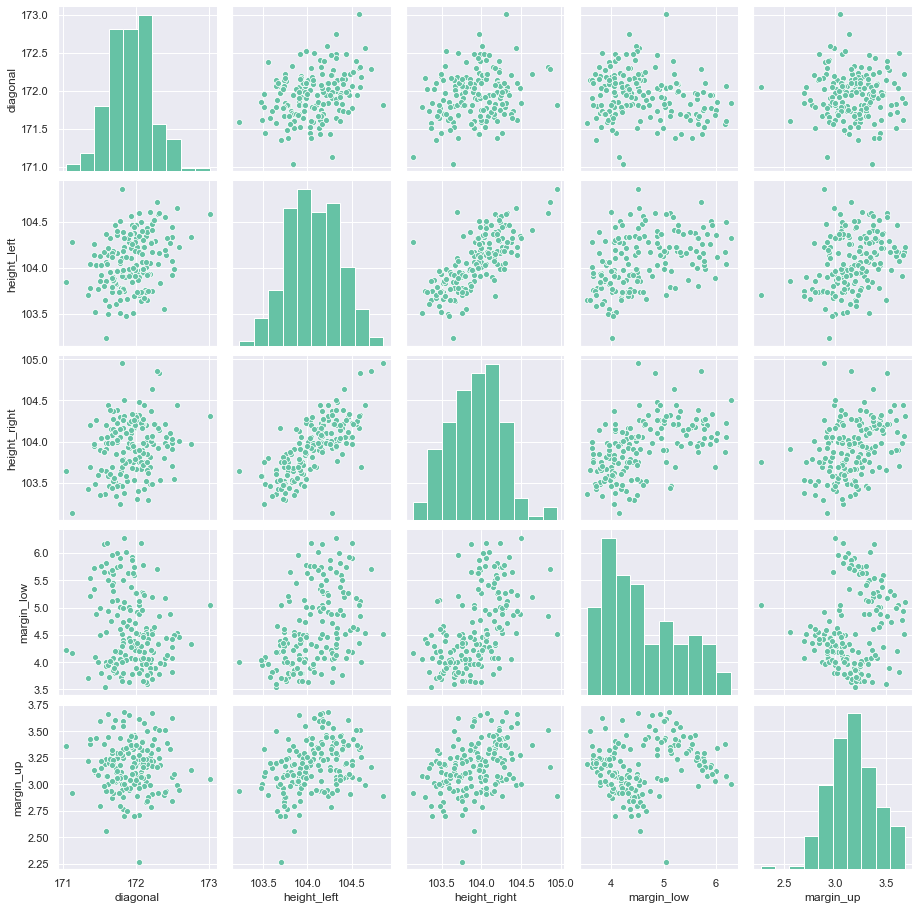

In [12]:
sns.pairplot(df.iloc[:,1:6])

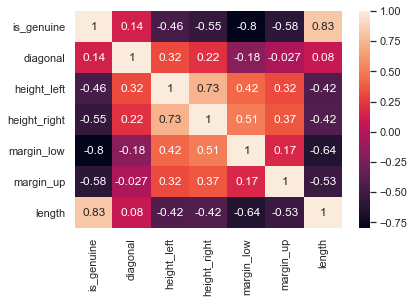

In [13]:
sns.heatmap(df.corr(),annot=True)

## Partie 1 : ANALYSE EN COMPOSANTES PRINCIPALES

Repartez de l'exploration via l'étude VISA pour cette partie + le cours sur OC
Dans tous les cas, je veux voir : 
    - un diagramme ebouli pour expliquer le pourcentage d'inertie de vos composantes principales
    - un cercle des corrélations de vos variables + l'interprétation de celui-ci
    - représentaiton des individus (= des billets) sur le plan factoriel

### Avec ou sans scale ? 

### sans

In [14]:
from sklearn.preprocessing import scale
pca = PCA()
# Sélection des variables quantitatives
dat=df.iloc[:,1:6]
# réduction
# composantes principales
C1 = pca.fit(dat).transform(dat)

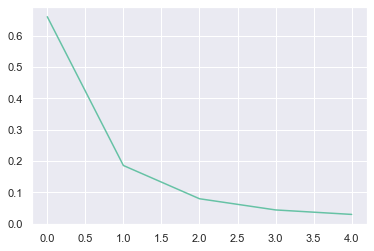

In [15]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

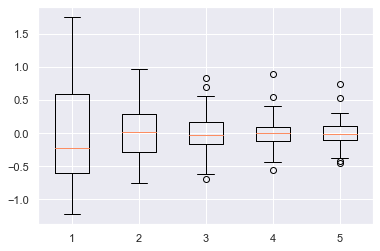

In [16]:
#Diagramme en boite représence nos composantes principales. 
plt.figure()
plt.boxplot(C1[:,0:6])
plt.show()

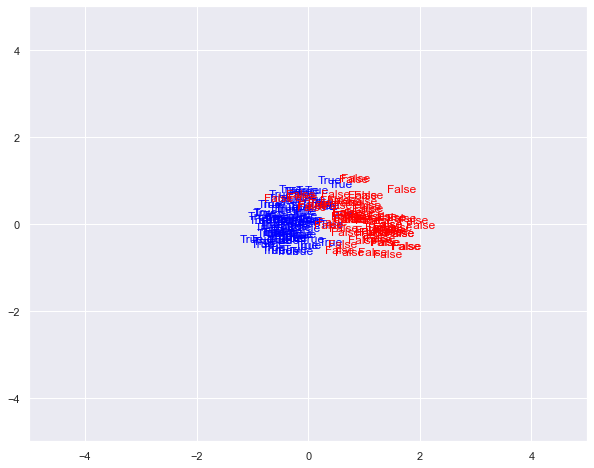

In [17]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C1[:,0], C1[:,1], df['is_genuine']):
    color = "red" if nom == False else "blue"
    plt.text(i, j, nom, color=color)
    plt.axis((-5,5,-5,5))
plt.show()

### Avec

In [18]:
from sklearn.preprocessing import scale
pca = PCA()
# Sélection des variables quantitatives
dat=df.iloc[:,1:6]
# réduction
data = pd.DataFrame(scale(dat),columns=dat.columns)
# composantes principales
C = pca.fit(data).transform(data)

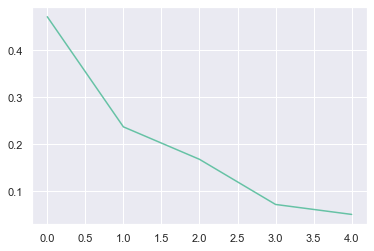

In [19]:
#Diagramme d'éboulis qui permet de visualiser nos dimensions. 
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()


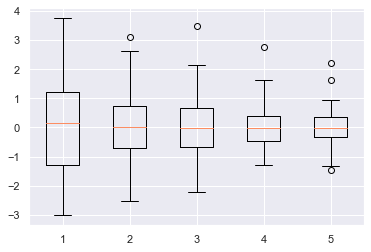

In [20]:
#Diagramme en boite représence nos composantes principales. 
plt.figure()
plt.boxplot(C[:,0:6])
plt.show()

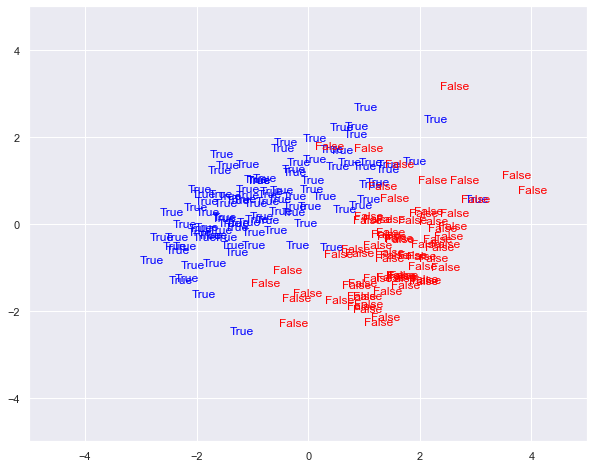

In [21]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], df['is_genuine']):
    color = "red" if nom == False else "blue"
    plt.text(i, j, nom, color=color)
    plt.axis((-5,5,-5,5))
plt.show()

### Avec log et Scale

In [22]:
def log1(x):
    return np.log(1+x)
dftrans=df
dftrans.iloc[:,1:]=log1(dftrans.iloc[:,1:])
dftrans

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,5.152193,4.662117,4.662967,1.708378,1.358409,4.734706
1,True,5.151382,4.651481,4.651099,1.611436,1.353255,4.738739
2,True,5.152308,4.651672,4.651672,1.686399,1.355835,4.743540
3,True,5.152135,4.651863,4.650621,1.553925,1.415853,4.741710
4,True,5.153581,4.651099,4.651577,1.798404,1.184790,4.741011
...,...,...,...,...,...,...,...
165,False,5.153927,4.656148,4.658237,1.830980,1.521699,4.725439
166,False,5.159113,4.659564,4.656908,1.798404,1.398717,4.717695
167,False,5.156005,4.656528,4.654912,1.771557,1.465568,4.715638
168,False,5.152251,4.653675,4.652817,1.745716,1.515127,4.726237


In [23]:
from sklearn.preprocessing import scale
pca = PCA()
# Sélection des variables quantitatives
dat=dftrans.iloc[:,1:]
# réduction
data = pd.DataFrame(scale(dat),columns=dat.columns)
# composantes principales
C2 = pca.fit(data).transform(data)

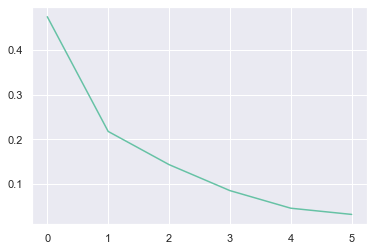

In [24]:
#Diagramme d'éboulis qui permet de visualiser nos dimensions. 
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

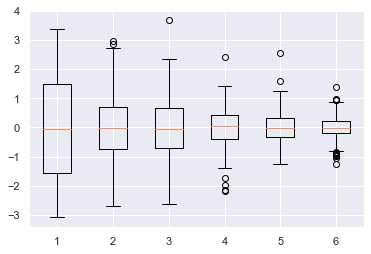

In [25]:
#Diagramme en boite représence nos composantes principales. 
plt.figure()
plt.boxplot(C2[:,0:6])
plt.show()

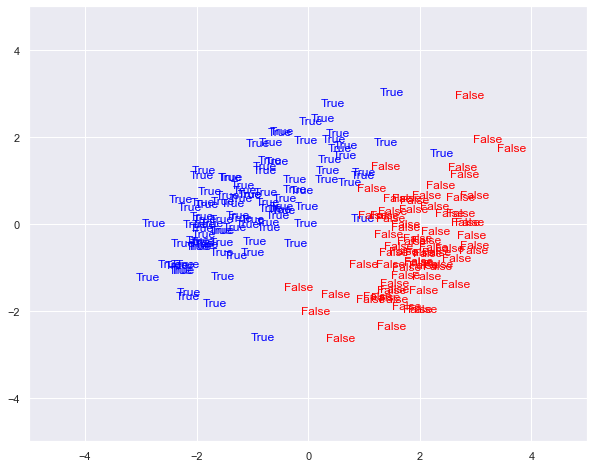

In [26]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C2[:,0], C2[:,1], dftrans['is_genuine']):
    color = "red" if nom == False else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-5,5,-5,5))
plt.show()

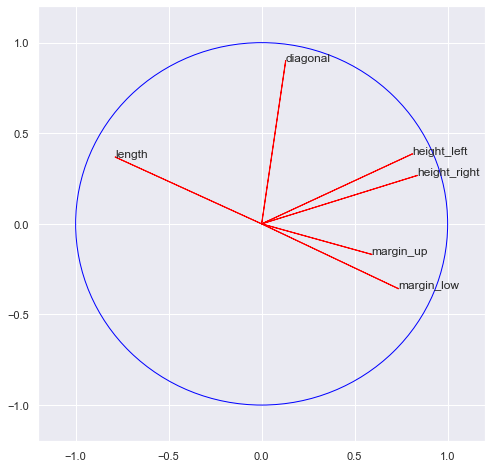

In [27]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

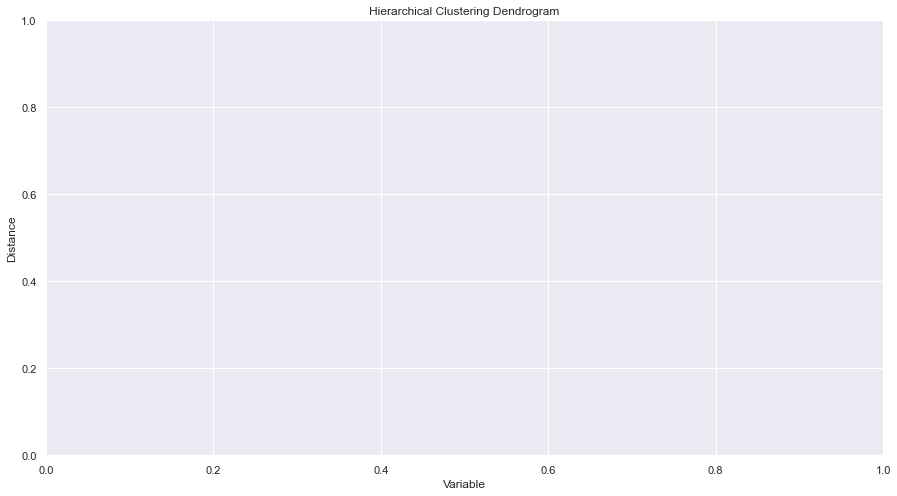

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data.T, 'ward')
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variable')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8.,labels=data.columns)
plt.show()

## Partie 2 : PREDICTION

Effectuer la prédiction de nouveaux billets via un algorithme que vous allez mettre en place (kmeans? regression logistique? A vous de voir).  
Si besoin, je vous fournirai un nouveau jeu de données de billets afin que vous prédisiez s'ils sont vrais ou faux et qu'on valide ensuite !

In [30]:
lr=LogisticRegression()
dftrans["pca1"]=C2[:,0]
dftrans['pca2']=C2[:,1]
dftrans['pca3']=C2[:,2]
dftrans


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,pca1,pca2,pca3
0,True,5.152193,4.662117,4.662967,1.708378,1.358409,4.734706,2.177896,1.562834,1.764835
1,True,5.151382,4.651481,4.651099,1.611436,1.353255,4.738739,-2.116541,-0.515379,0.553185
2,True,5.152308,4.651672,4.651672,1.686399,1.355835,4.743540,-1.945717,-0.047994,0.893682
3,True,5.152135,4.651863,4.650621,1.553925,1.415853,4.741710,-2.086117,-0.067938,-0.593462
4,True,5.153581,4.651099,4.651577,1.798404,1.184790,4.741011,-2.503984,0.495292,3.701151
...,...,...,...,...,...,...,...,...,...,...
165,False,5.153927,4.656148,4.658237,1.830980,1.521699,4.725439,2.465114,0.179148,-0.746595
166,False,5.159113,4.659564,4.656908,1.798404,1.398717,4.717695,2.631552,2.882677,0.574605
167,False,5.156005,4.656528,4.654912,1.771557,1.465568,4.715638,2.102326,0.811001,-0.586396
168,False,5.152251,4.653675,4.652817,1.745716,1.515127,4.726237,0.737411,-0.993158,-1.269949


In [31]:
dftrans["is_genuine"]=dftrans["is_genuine"].replace(True,1)
dftrans["is_genuine"]=dftrans['is_genuine'].replace(False,0)

In [32]:
from sklearn.model_selection import train_test_split

data_Tr, data_Te, target_Tr, target_Te = train_test_split(dftrans.iloc[:,7:9], df.is_genuine
                                 , random_state=0
                                 , train_size=0.75)


In [33]:
lr.fit(data_Tr,target_Tr)

LogisticRegression()

In [34]:
result=lr.predict(data_Te)

In [41]:
lr.predict_proba(data_Te)

array([[9.93313465e-01, 6.68653450e-03],
       [9.75871951e-01, 2.41280491e-02],
       [8.30672483e-01, 1.69327517e-01],
       [1.67768465e-03, 9.98322315e-01],
       [3.79533213e-03, 9.96204668e-01],
       [3.20281052e-01, 6.79718948e-01],
       [7.95064102e-04, 9.99204936e-01],
       [2.16118177e-01, 7.83881823e-01],
       [9.94681171e-01, 5.31882864e-03],
       [1.18845927e-02, 9.88115407e-01],
       [7.60612802e-01, 2.39387198e-01],
       [1.27028950e-01, 8.72971050e-01],
       [2.05811304e-02, 9.79418870e-01],
       [9.73985631e-01, 2.60143686e-02],
       [7.71272412e-04, 9.99228728e-01],
       [2.48044460e-03, 9.97519555e-01],
       [5.95111016e-04, 9.99404889e-01],
       [9.97777121e-01, 2.22287942e-03],
       [8.32878290e-04, 9.99167122e-01],
       [2.33714584e-02, 9.76628542e-01],
       [9.96111451e-01, 3.88854865e-03],
       [1.98953178e-04, 9.99801047e-01],
       [7.77946895e-01, 2.22053105e-01],
       [9.65199171e-01, 3.48008292e-02],
       [9.574079

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
#On calcul la précision(Accuracy ) avec un score en %
accuracy=accuracy_score(result, target_Te)
recall= recall_score(result, target_Te, average=None)
precision= precision_score(result, target_Te, average=None)
F1= f1_score(result, target_Te, average=None)
#100 % avec 80 / 20 j'ai testé 50 / 50 pour tester j'obtiens 0.93

print("R =", recall) # précision de prédiction des valeur Positive correctement prédit
#par rapport à l'ensemble des vrais valeurs
print("A =", accuracy) # Précision sur l'ensemble des bon résultat (True positive and True neg) par rapport
#A l'ensmble des valeurs.
print("P =", precision)# Précision de prédiction des valeurs Positive par rapport à tout les donnée prédite 
#postif. 
print('F1 =', F1) #Valeur qui fait la balance entre recall et precision pour avoir une valeur qui maximise les 
#deux valeurs

In [ ]:
conf= confusion_matrix(target_Te, result)
conf

In [ ]:
sns.heatmap(conf, annot=True)

In [ ]:
sns.scatterplot(dftrans.pca1, dftrans.pca2, hue=dftrans.iloc[:,0])

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(dftrans.iloc[:,7:9])
visualizer.show()